This notebook demonstrates how a DAG can be used in combination with the assignment of a distribution to each node and a weight to each edge to create a linear SCM.

In [1]:
import sys
import time
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import normal, uniform

from y0.algorithm.estimation.linear_scm import get_single_door
from y0.dsl import V1, V2, V3, V4, V5, V6, Z1, Z2, X, Y, Z
from y0.examples import backdoor_example, frontdoor_example, napkin_example
from y0.graph import NxMixedGraph
from y0.simulation import example_generators, example_graph, get_fits_df, simulate

In [2]:
print(sys.version)

3.11.7 (main, Dec  4 2023, 18:10:11) [Clang 15.0.0 (clang-1500.1.0.2.5)]


In [3]:
print(time.asctime())

Thu Mar 21 09:59:55 2024


In [4]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

In [5]:
np.random.seed(42)

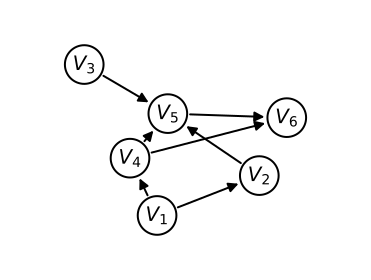

In [6]:
example_graph.draw(prog="neato")

In [7]:
example_graph.to_linear_scm_latex()

'\\begin{align*}V_1 &= \\epsilon_{V_1} \\\\\n V_3 &= \\epsilon_{V_3} \\\\\n V_2 &= V_{1} \\beta_{V_1,V_2} + \\epsilon_{V_2} \\\\\n V_4 &= V_{1} \\beta_{V_1,V_4} + \\epsilon_{V_4} \\\\\n V_5 &= V_{2} \\beta_{V_2,V_5} + V_{3} \\beta_{V_3,V_5} + V_{4} \\beta_{V_4,V_5} + \\epsilon_{V_5} \\\\\n V_6 &= V_{4} \\beta_{V_4,V_6} + V_{5} \\beta_{V_5,V_6} + \\epsilon_{V_6} \\\\\\end{align*}'

## Simulating Data

It's possible to simulate data using a linear structural causal model (SCM) given the following:

1. A directed acyclic graph (DAG) structure
2. A scalar weight for each edge in the DAG
3. A probability distribution for each node

In [8]:
df, fits = simulate(example_graph, generators=example_generators, trials=5000)

Ultimately the simulation provides _trials_ number of data points:

In [9]:
df

,V1,V3,V2,V4,V5,V6
0,0.732352,1.579213,-1.643367,2.231127,3.043934,-0.585489
1,-0.636350,0.542560,-1.504721,-0.121063,-1.550738,-6.000635
2,-0.417542,-1.012831,-0.987808,0.231532,-1.445118,4.207639
3,-0.600652,-0.225776,-0.168031,-1.659814,-0.484504,-0.001774
4,-0.658952,-0.600639,0.490128,-1.209862,-0.759496,-0.347730
...,...,...,...,...,...,...
4995,0.424646,1.541836,2.106960,-0.952572,-0.953767,-6.989704
4996,-0.215569,-0.884968,-1.352523,1.215740,-1.055379,1.363805
4997,0.915159,1.149941,1.960925,1.943799,2.759274,-6.626966
4998,-0.731785,-0.244299,-1.914631,-1.350269,0.040974,-3.152545


The simulation also performs several calculations over each pair of variables:

1. What's the correlation coefficient ($r^2$) between the variables?
2. Are the variables d-separated (i.e., conditionally independent)?

In [10]:
param_df = get_fits_df(fits)
param_df

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,V2,V1,0.342235,0.001528,0.027947,False,None
1,V4,V1,0.948344,0.031976,0.069679,False,None
2,V2,V5,0.787859,0.010404,0.161082,False,None
3,V5,V4,0.619390,-0.005256,0.306609,False,None
4,V4,V6,0.254030,0.025847,0.030339,False,None
5,V5,V6,0.216792,0.029765,0.027648,False,None
6,V5,V3,0.015782,0.008817,0.000046,False,None
7,V1,V3,-0.020958,0.018490,0.000147,True,()
8,V5,V1,0.815710,0.016662,0.041200,True,"(V2, V4)"
9,V6,V1,0.242835,0.033988,0.002148,True,"(V2, V4)"


The following plot demonstrates that variables that are d-separated (i.e., conditionally independent) have effectively no correlation.

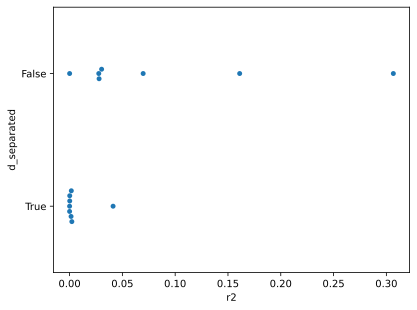

In [11]:
sns.swarmplot(data=param_df, y="d_separated", x="r2", orient="h")
plt.show()

In the following, we estimate parameter values for a linear SCM using backdoor adjustment

In [12]:
edge_parameters = get_single_door(example_graph, df)
edge_parameters

{(V1, V2): 0.3422347361951545,
 (V1, V4): 0.9483436342863191,
 (V2, V5): 0.74347353010935,
 (V4, V5): 0.6017577399442859,
 (V4, V6): 0.25304936952462576,
 (V5, V6): 0.13130009315811506,
 (V3, V5): 0.01578243222296311}

## Backdoor example

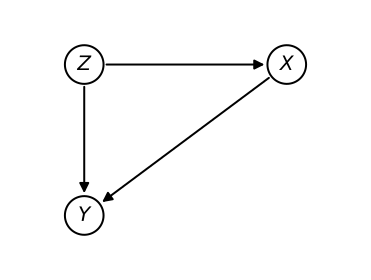

In [13]:
backdoor_example.graph.draw()

In [14]:
backdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}Z &= \\epsilon_{Z} \\\\\n X &= Z \\beta_{Z,X} + \\epsilon_{X} \\\\\n Y &= X \\beta_{X,Y} + Z \\beta_{Z,Y} + \\epsilon_{Y} \\\\\\end{align*}'

In [15]:
backdoor_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z: partial(normal, loc=0.0, scale=1.0),
}

In [16]:
backdoor_df, backdoor_fits = simulate(
    backdoor_example.graph, generators=backdoor_generators, trials=5000
)

In [17]:
backdoor_df.to_csv("../tests/test_algorithm/backdoor_example.csv")
backdoor_df

,Z,X,Y
0,0.386225,0.740843,1.512332
1,0.187842,0.651570,-0.407257
2,0.765027,0.677756,0.658799
3,0.690842,1.071151,1.903609
4,1.081655,1.492234,-0.138313
...,...,...,...
4995,-0.930339,-1.127930,0.146051
4996,-0.603780,0.130166,-0.668436
4997,-0.679812,-1.319354,1.120110
4998,-0.327085,-0.544447,-1.932424


In [18]:
get_fits_df(backdoor_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z,X,0.790732,0.000785,0.652027,False,None
1,Z,Y,0.617133,-0.022319,0.217295,False,None
2,Y,X,0.645104,-0.026177,0.227690,False,None


In [19]:
backdoor_parameters = get_single_door(backdoor_example.graph, backdoor_df)
backdoor_parameters

{(Z, X): 0.7907318246822707,
 (Z, Y): 0.617132817314764,
 (X, Y): 0.391480661130627}

## Frontdoor example

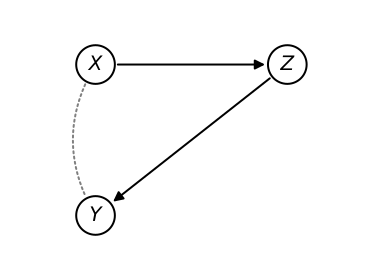

In [20]:
frontdoor_example.graph.draw()

In [21]:
frontdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}X &= \\epsilon_{X} + \\gamma_{X,Y} \\\\\n Z &= X \\beta_{X,Z} + \\epsilon_{Z} \\\\\n Y &= Z \\beta_{Z,Y} + \\epsilon_{Y} + \\gamma_{X,Y} \\\\\\end{align*}'

In [22]:
frontdoor_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z: partial(normal, loc=0.0, scale=1.0),
}

In [23]:
frontdoor_df, frontdoor_fits = simulate(
    frontdoor_example.graph, generators=frontdoor_generators, trials=5000
)

In [24]:
frontdoor_df.to_csv("../tests/test_algorithm/frontdoor_example.csv")
frontdoor_df

,X,Z,Y
0,0.759915,-1.060574,0.207893
1,-0.916988,-0.352503,-0.329748
2,0.180628,-0.075129,1.051833
3,-0.734600,0.153517,-0.248565
4,-0.553731,-2.763078,1.611259
...,...,...,...
4995,0.077387,1.264306,-0.280449
4996,-0.752369,0.817562,1.336690
4997,-0.943263,-0.625236,-1.508562
4998,0.511802,1.286444,0.394047


In [25]:
get_fits_df(frontdoor_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z,X,0.176472,0.011759,0.010141,False,None
1,Z,Y,0.117898,0.032683,0.010557,False,None
2,Y,X,0.027675,0.034076,0.000189,False,None


In [26]:
frontdoor_parameters = get_single_door(frontdoor_example.graph, frontdoor_df)
frontdoor_parameters

{(X, Z): 0.17647247252670073, (Z, Y): 0.11749890938707913}

## Napkin example

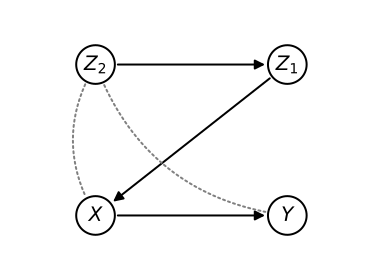

In [27]:
napkin_example.graph.draw()

In [28]:
napkin_example.graph.to_linear_scm_latex()

'\\begin{align*}Z_2 &= \\epsilon_{Z_2} + \\gamma_{X,Z_2} + \\gamma_{Y,Z_2} \\\\\n Z_1 &= Z_{2} \\beta_{Z_2,Z_1} + \\epsilon_{Z_1} \\\\\n X &= Z_{1} \\beta_{Z_1,X} + \\epsilon_{X} + \\gamma_{X,Z_2} \\\\\n Y &= X \\beta_{X,Y} + \\epsilon_{Y} + \\gamma_{Y,Z_2} \\\\\\end{align*}'

In [29]:
napkin_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z1: partial(normal, loc=0.0, scale=1.0),
    Z2: partial(normal, loc=0.0, scale=1.0),
}

In [30]:
napkin_df, napkin_fits = simulate(napkin_example.graph, generators=napkin_generators, trials=5000)

In [31]:
napkin_df.to_csv("../tests/test_algorithm/napkin_example.csv")
napkin_df

,Z2,Z1,X,Y
0,0.531994,0.923442,0.603730,-1.031035
1,-0.481438,-2.514669,-0.917261,0.312005
2,0.183411,0.192907,0.247373,-0.407830
3,-0.628421,0.519845,0.076638,-1.777506
4,0.316858,-1.704033,0.368891,-1.600906
...,...,...,...,...
4995,1.624088,0.857137,-0.404861,-0.187662
4996,-0.052671,0.913962,-0.596824,0.712051
4997,-0.669210,-1.329458,0.916215,-1.594475
4998,0.953128,-1.209994,-0.809793,-1.850732


In [32]:
get_fits_df(napkin_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z1,Z2,0.941043,0.007161,4.668063e-01,False,None
1,Z1,X,0.023516,-0.000405,3.225205e-03,False,None
2,Y,X,0.014115,0.008885,4.908618e-05,False,None
3,X,Z2,0.078986,-0.007204,2.029340e-03,False,None
4,Z1,Y,0.015809,0.000212,1.739209e-04,True,"(X, Z2)"
5,Y,Z2,-0.000270,-0.007233,9.628307e-08,False,None


In [33]:
napkin_parameters = get_single_door(napkin_example.graph, napkin_df)
napkin_parameters

{(Z2, Z1): 0.941043027106573, (Z1, X): 0.02020145142865377}